In [1]:
import os
os.chdir('../')

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import torch

def get_cached_data(data_path):
    data = torch.load(data_path)
    
    image = data["image"]
    depth_gt = data["gt"].squeeze()
    depth_gt_sparse = data["dep"].squeeze()
    depth_pred = data["depth_pred"]
    
    return image, depth_gt, depth_gt_sparse, depth_pred

data_path = "/data2/wlsgur4011/SparseDC/datas/cache_prev/1.marigold(vanilla)_0f46ecad380de3e24d0689d19c70765b.pt"
image, depth_gt, depth_gt_sparse, depth_pred = get_cached_data(data_path)

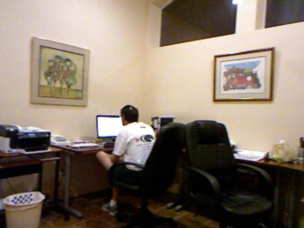

In [4]:
image

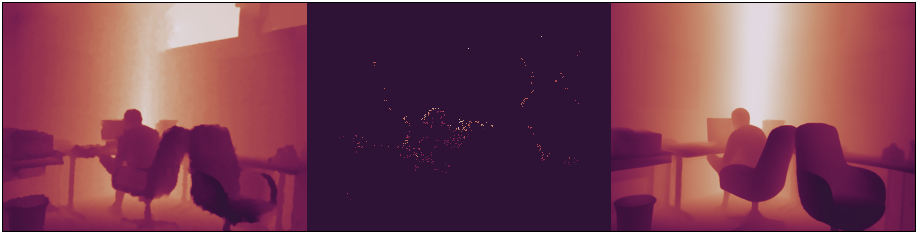

In [5]:
from jhutil import show_depth_all

show_depth_all(depth_gt, depth_gt_sparse, depth_pred)

[2024-02-20 20:59:53] [INFO] Created a temporary directory at /tmp/tmpurklqjki
[2024-02-20 20:59:53] [INFO] Writing /tmp/tmpurklqjki/_remote_module_non_scriptable.py


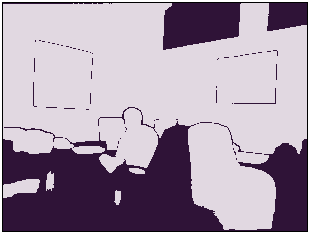

In [6]:
import PIL
from src.utils.depth_utils import get_depth_affine, get_depth_dbscan, get_depth_sam
from src.utils.depth_utils import *

sam = None
clusters = None

def get_depth_sam(rgb, depth_pred, depth_gt_sparse, scale_margin=100, shift_margin=100, err_margin=0.1):
    if isinstance(rgb, PIL.Image.Image):
        rgb = np.array(rgb)
    
    global sam, clusters
    if sam is None:
        sam_checkpoint = "/data2/wlsgur4011/SparseDC/pretrain/sam_vit_h_4b8939.pth"
        model_type = "vit_h"
        model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        model.to(device="cuda")
        sam = SamAutomaticMaskGenerator(model)
    clusters = sam.generate(rgb)
    global_scale, global_shift = compute_scale_and_shift(depth_pred, depth_gt_sparse, mask=(depth_gt_sparse != 0))

    depth_sum = torch.zeros_like(depth_pred)
    depth_n = torch.zeros_like(depth_pred)
    
    for i, cluster in enumerate(clusters):
        cluster = torch.tensor(cluster['segmentation']).cuda()
        cluster_depth = cluster * depth_gt_sparse

        mask = cluster_depth != 0
        
        err = torch.ones(100)
        
        while True:
            if mask.sum() <= 3:
                break
            
            scale, shift = compute_scale_and_shift(depth_pred, depth_gt_sparse, mask)
            # TODO: reject
            err = ((scale * depth_pred + shift) - depth_gt_sparse).abs()
            err[~mask] = 0
            
            if (err < err_margin).all():
                break
            else:
                # Replace the maximum value with 0
                mask[err == err.max()] = 0
        
        # n sample must be larger than 3
        if mask.sum() <= 3:
            continue
        
        if abs(scale - global_scale) > scale_margin or abs(shift - global_shift) > shift_margin:
            continue
        
        depth_sum[cluster] += scale * depth_pred[cluster] + shift
        depth_n += cluster
    
    
    new_depth = torch.zeros_like(depth_pred)
    
    sam_mask = depth_n != 0
    new_depth[sam_mask] = depth_sum[sam_mask] / depth_n[sam_mask]
    new_depth[~sam_mask] = (global_scale * depth_pred + global_shift)[~sam_mask]
    
    return new_depth, sam_mask


new_depth, sam_mask = get_depth_sam(image, depth_pred, depth_gt_sparse)
sam_mask.chans

1111  "tensor[228, 304] n=69312 (0.3Mb) x∈[-10.000, 1.000] μ=0.612 σ=0.902 cuda:0"
1111  "tensor cuda:0 0.104"
2222  "tensor cuda:0 0.072"


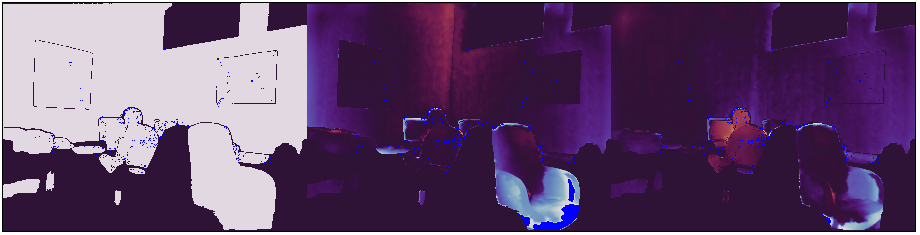

In [7]:
def compare_sam_and_affine(rgb, depth_pred, depth_gt_sparse):
    mask_sparse = depth_gt_sparse != 0
    
    depth_dbscan, sam_mask = get_depth_sam(rgb, depth_pred, depth_gt_sparse)
    depth_affine = get_depth_affine(depth_pred, depth_gt_sparse)
    
    diff_sam = (depth_dbscan - depth_gt) * sam_mask
    diff_affine = (depth_affine - depth_gt) * sam_mask
    
    err_sam = diff_sam.abs().mean()
    err_affine = diff_affine.abs().mean()
    sam_mask = sam_mask.float()
    sam_mask[depth_gt_sparse != 0] = -10
    import jhutil; jhutil.jhprint(1111, sam_mask)
    diff_sam[depth_gt_sparse != 0] = -10
    diff_affine[depth_gt_sparse != 0] = -10
    visualization = torch.concat([sam_mask, diff_sam, diff_affine], dim=1).chans
    
    return err_sam, err_affine, visualization

err_sam, err_affine, visualization = compare_sam_and_affine(image, depth_pred, depth_gt_sparse)

import jhutil; jhutil.jhprint(1111, err_sam)
import jhutil; jhutil.jhprint(2222, err_affine)
visualization

In [8]:
import numpy as np
data_folder = "/data2/wlsgur4011/SparseDC/datas/cache_prev"
data_path_iter = iter(os.listdir(data_folder))

In [14]:
while True:
    data_path = os.path.join(data_folder, next(data_path_iter))
    image, depth_gt, depth_gt_sparse, depth_pred = get_cached_data(data_path)
    err_sam, err_affine, visualization = compare_sam_and_affine(image, depth_pred, depth_gt_sparse)
    import jhutil; jhutil.jhprint(1111, err_sam)
    import jhutil; jhutil.jhprint(2222, err_affine)
    break
visualization

StopIteration: 